In [12]:
import tensorflow as tf
from tensorflow import keras


import generator_model
import generator_model2
import generator_model3
import generator_model4
import discriminator_model
import discriminator_model2
import WGAN_model2
import discriminator_modelWGAN
import generator_pretrain
import generator_pretrain_cycle
import Callbacks

In [6]:
import math
import pickle
import glob
from pathlib import Path

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from AnnotationData import AnnotationData
%load_ext autoreload
%autoreload 2

In [3]:
folder = "D:/FER/IstrazivackiSeminar"
backgrounds_path = "D:/FER/IstrazivackiSeminar/empty_labels/"
batch_size = 32
image_size = (128,128)

In [4]:
def loadAnnotation(input_folder):
    data = []
    paths = glob.glob(input_folder + "/**/*.pkl", recursive=True)
    for path in paths:
        with open(path, "rb") as file:
            annotations = pickle.load(file)
        annotationsArray = [(str(Path(path).parent) + "\\" + name, ant) for (name, ant) in annotations]
        data += annotationsArray
    return data

In [7]:
annotation = loadAnnotation(folder)

In [8]:
class GAN_Dataset(keras.utils.Sequence):
    def __init__(self, data, batch_size, image_size, backgrounds_path):
        self.image_size = image_size
        self.data = data
        self.batch_size = batch_size
        self.backgrounds_path = backgrounds_path
        self.bacgrounds = np.array([self.loadImage(path) for path in glob.glob(self.backgrounds_path +"/*")])

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size) - 1

    def __getitem__(self, idx):
        images = np.array([self.loadImage(name) for (name, ant) in self.data[idx * self.batch_size: (idx + 1) * self.batch_size]])
        annotation = np.array([np.expand_dims(ant.astype(np.float32), -1) for (name, ant) in self.data[idx * self.batch_size: (idx + 1) * self.batch_size]])
        bg_indices = np.random.choice(self.bacgrounds.shape[0], images.shape[0])
        bg = self.bacgrounds[bg_indices]
        return images, annotation, bg
            
    def loadImage(self, path):
        img = Image.open(path).resize(self.image_size)
        img = np.array(img, dtype=np.float32) / 255
        return np.expand_dims(img, -1)
 

In [9]:
dataset = GAN_Dataset(annotation, batch_size, image_size, backgrounds_path)

In [42]:
generator = generator_model3.model(image_size, 1,1, channels=[16, 16, 32, 64, 128, 128], concat_channels=[64, 64, 64, 7]
)
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 10, 10, 1)]  0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 10, 10, 1)]  0                                            
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 10, 10, 2)    0           input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_transpose_22 (Conv2DTran (None, 16, 16, 64)   6336        concatenate_14[0][0]     

In [13]:
discriminator = discriminator_modelWGAN.model(image_size, 1, channels=[64,128,256,64,128,128,64], up_channels=[32, 32, 7])
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 10, 10, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_transpose_11 (Conv2DTran (None, 16, 16, 32)   1600        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose_12 (Conv2DTran (None, 64, 64, 32)   9248        conv2d_transpose_11[0][0]        
__________________________________________________________________________________________________
conv2d_transpose_13 (Conv2DTran (None, 128, 128, 7)  2023        conv2d_transpose_12[0][0]        
______________________________________________________________________________________

In [14]:
showCallbacks = Callbacks.ShowGeneratedImages(dataset)

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

vgg = VGG16(include_top=False, weights='imagenet')
vgg.trainable = False
selected_layers = ['block3_conv3', 'block4_conv3']
outputs = [vgg.get_layer(layer).output for layer in selected_layers]
feature_extractor = Model(inputs=vgg.input, outputs=outputs)

@tf.function
def perceptual_loss(y_true, y_pred):
    
    true_features = feature_extractor(tf.concat([y_true, y_true, y_true], axis = -1))
    pred_features = feature_extractor(tf.concat([y_pred, y_pred, y_pred], axis = -1))
    loss = 0.0
    for true_feature, pred_feature in zip(true_features, pred_features):
        loss += tf.reduce_mean(tf.square(true_feature - pred_feature))
    return loss

In [16]:
def identity_loss(true, preds):
    ssim_m = tf.image.ssim_multiscale(true,preds, max_val=1.0,filter_size=8)
    return 1 - tf.reduce_mean(ssim_m)

In [32]:
pretrain = generator_pretrain.GAN_model(
    generator=generator, batch_size = batch_size, label_size = (10,10)
)
pretrain.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=perceptual_loss
    
)


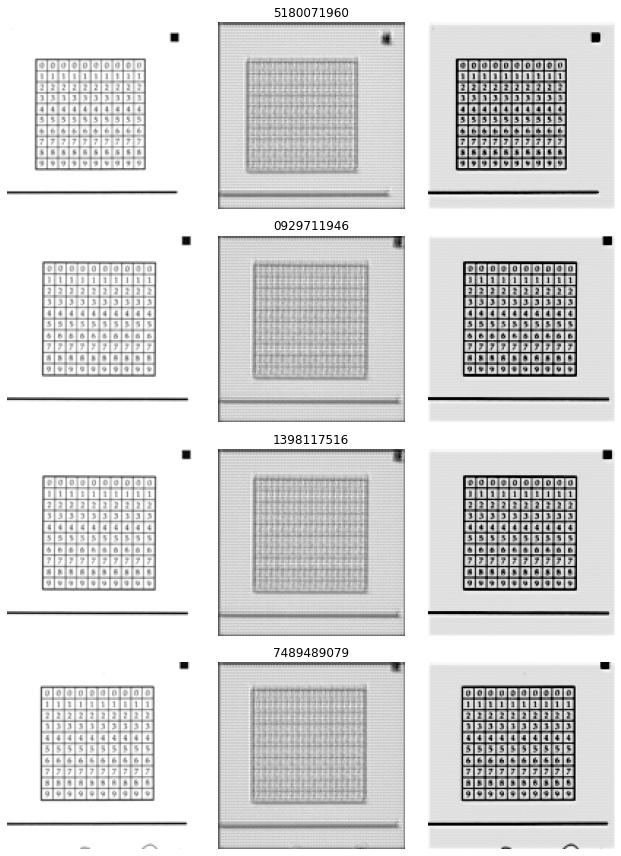

Epoch 1/10
112/112 [==============================] - 63s 439ms/step - loss: 34.6337


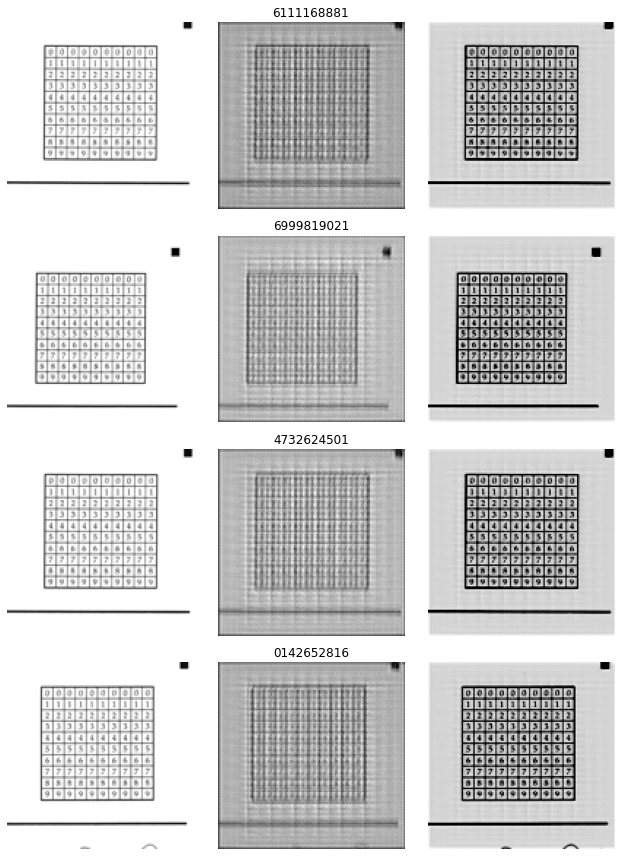

Epoch 2/10
112/112 [==============================] - 47s 414ms/step - loss: 32.6564


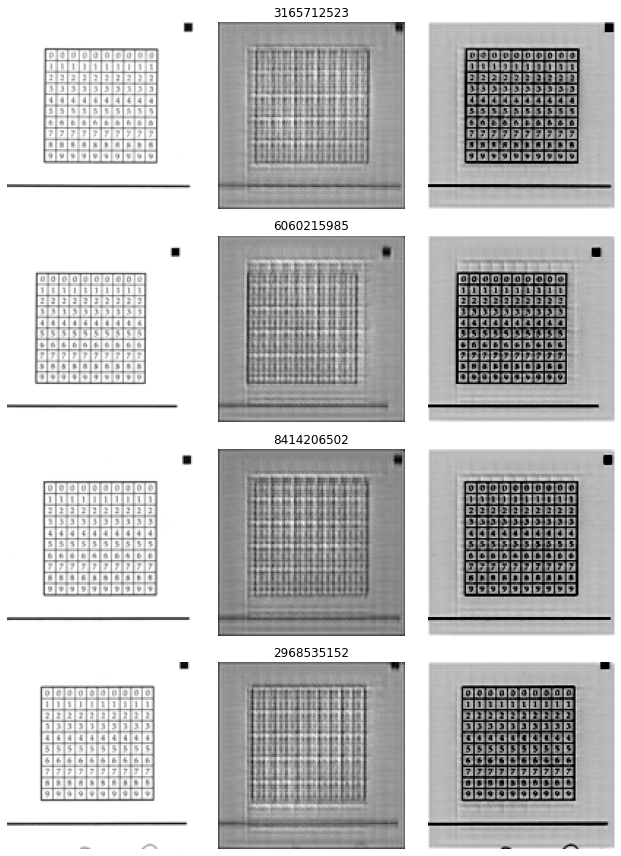

Epoch 3/10
112/112 [==============================] - 47s 414ms/step - loss: 31.5656


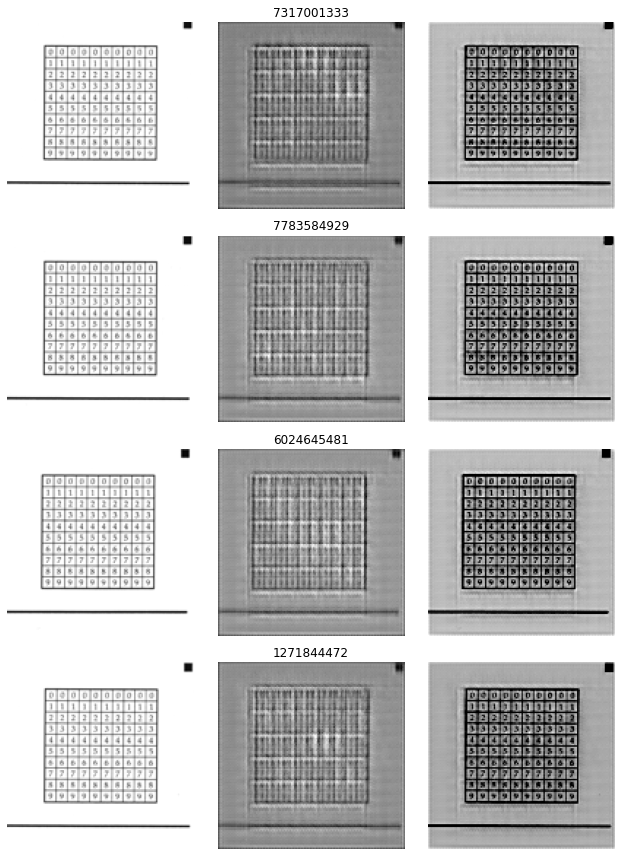

Epoch 4/10
112/112 [==============================] - 45s 404ms/step - loss: 30.7640


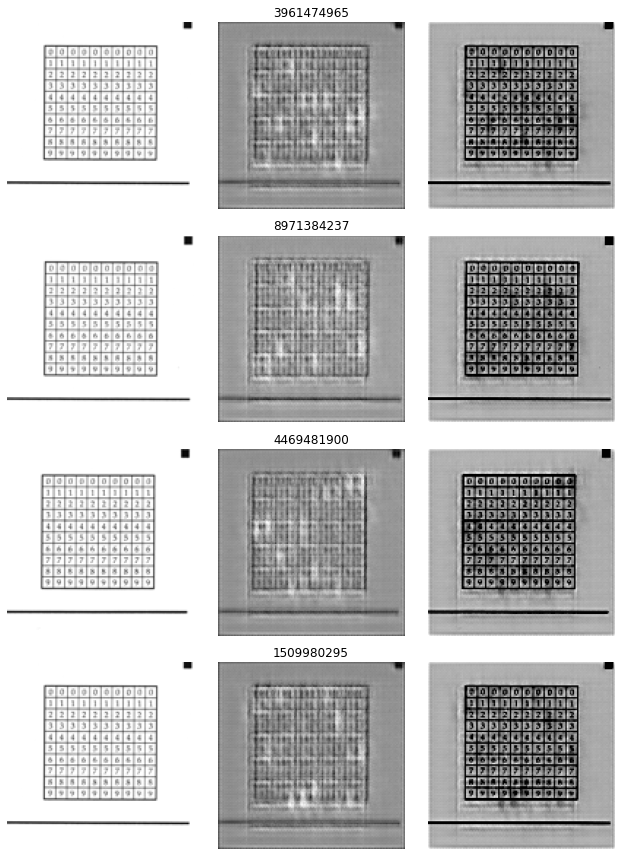

Epoch 5/10
112/112 [==============================] - 47s 417ms/step - loss: 29.4552


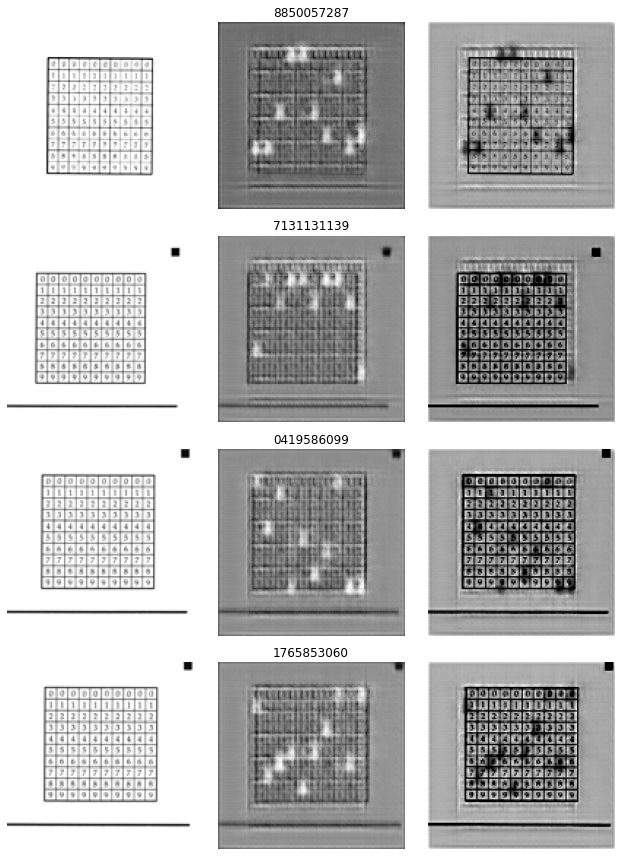

Epoch 6/10
112/112 [==============================] - 47s 416ms/step - loss: 28.9026


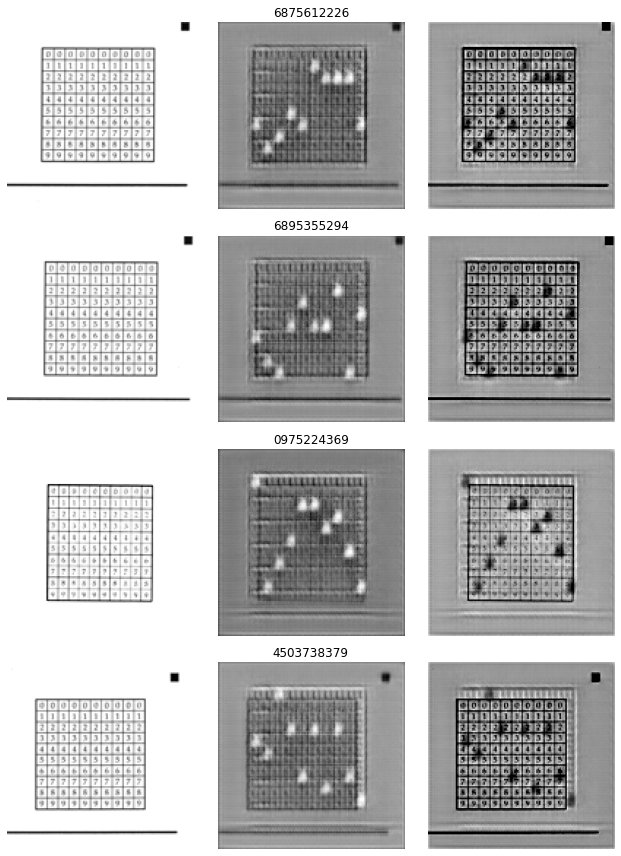

Epoch 7/10
112/112 [==============================] - 45s 401ms/step - loss: 28.6059


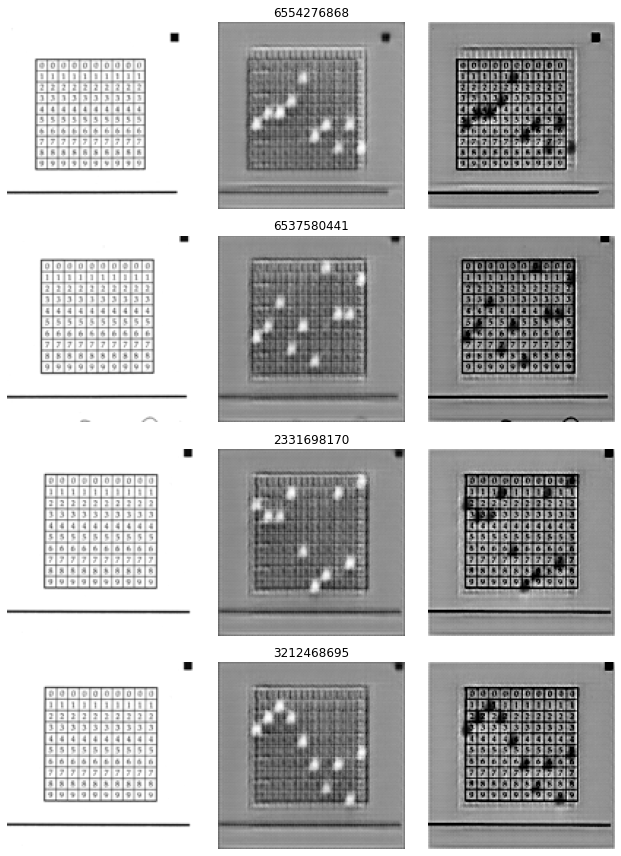

Epoch 8/10
112/112 [==============================] - 46s 409ms/step - loss: 28.0983


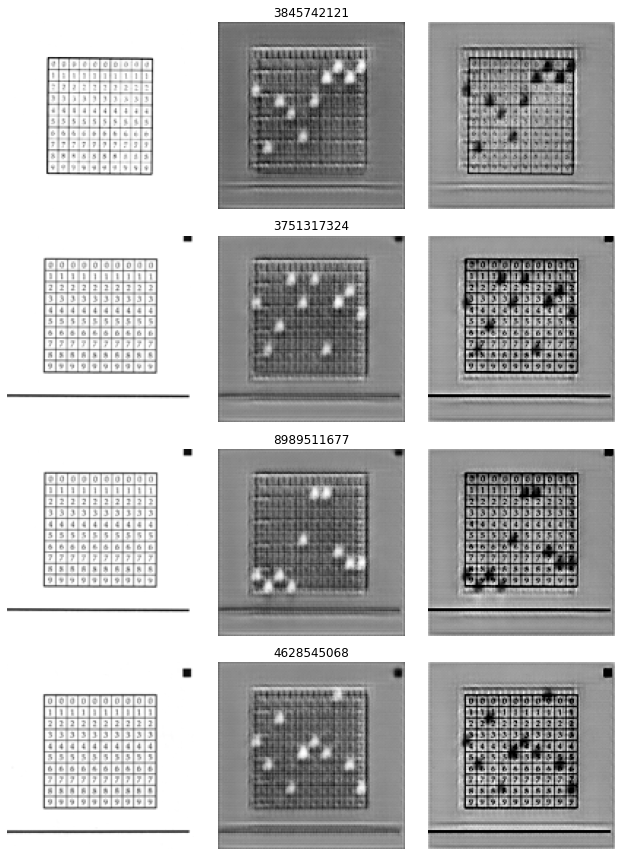

Epoch 9/10
112/112 [==============================] - 47s 414ms/step - loss: 27.7306


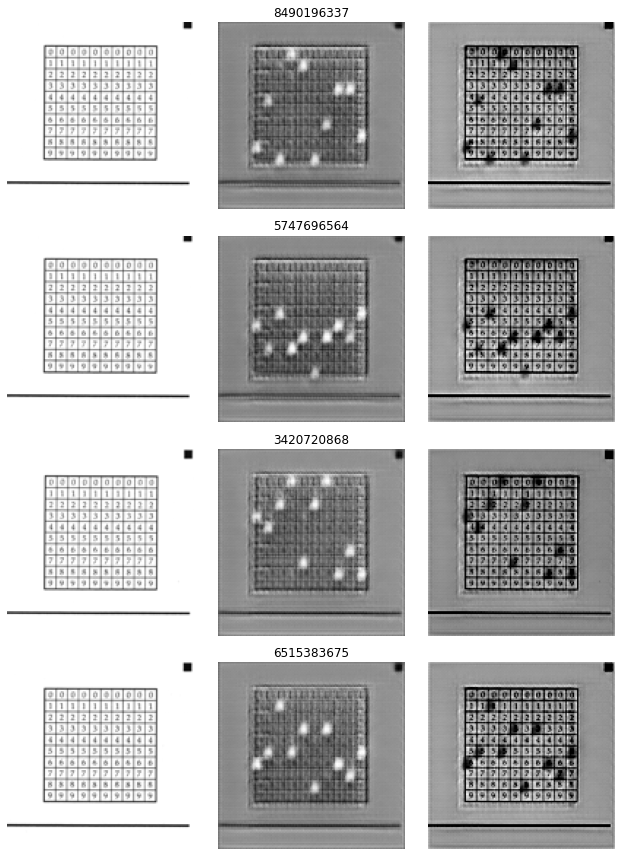

Epoch 10/10
112/112 [==============================] - 46s 406ms/step - loss: 27.5995


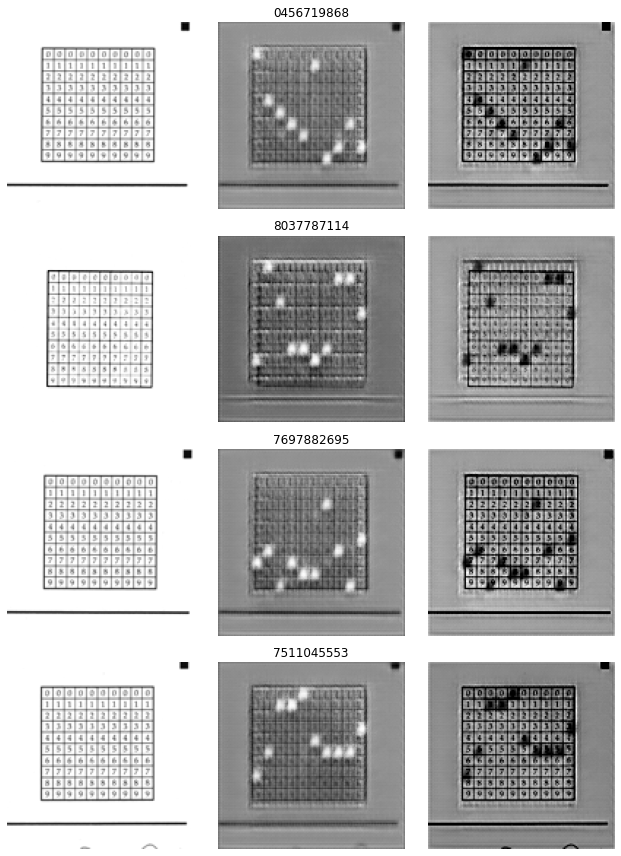

In [34]:
pretrain.fit(dataset, epochs=10, callbacks=[showCallbacks])

In [43]:
cond_gan = WGAN_model2.GAN_model(
    discriminator=discriminator, generator=generator, batch_size = batch_size, label_size = (10,10), num_dis_updates=3, num_gen_updates=1, alfa = 0.01
)
cond_gan.compile(
    d_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9),
    identity_loss=perceptual_loss
    
)



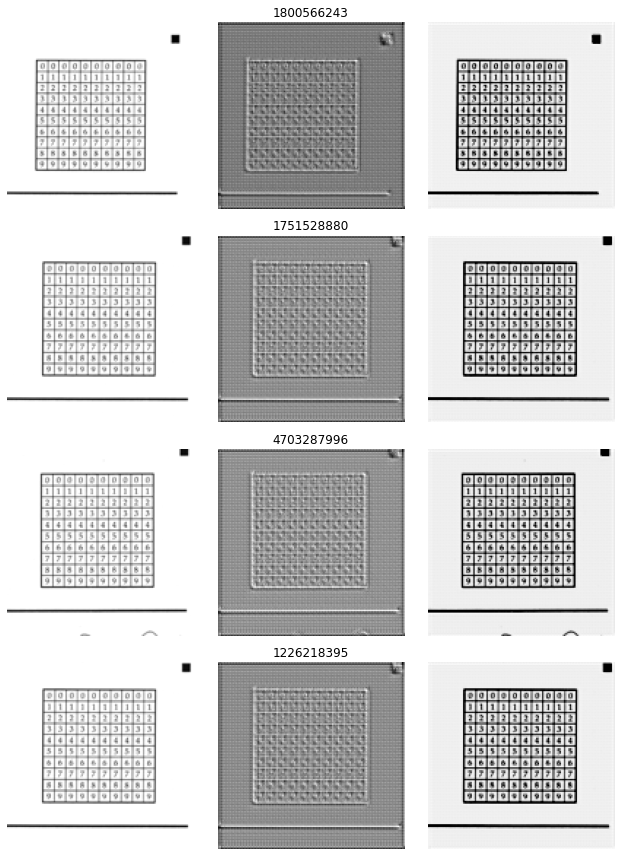

Epoch 1/10
112/112 [==============================] - 115s 950ms/step - d_loss: -5807111245.0973 - g_wg_loss: -1296327683.6637 - g_id_loss: 0.0000e+00


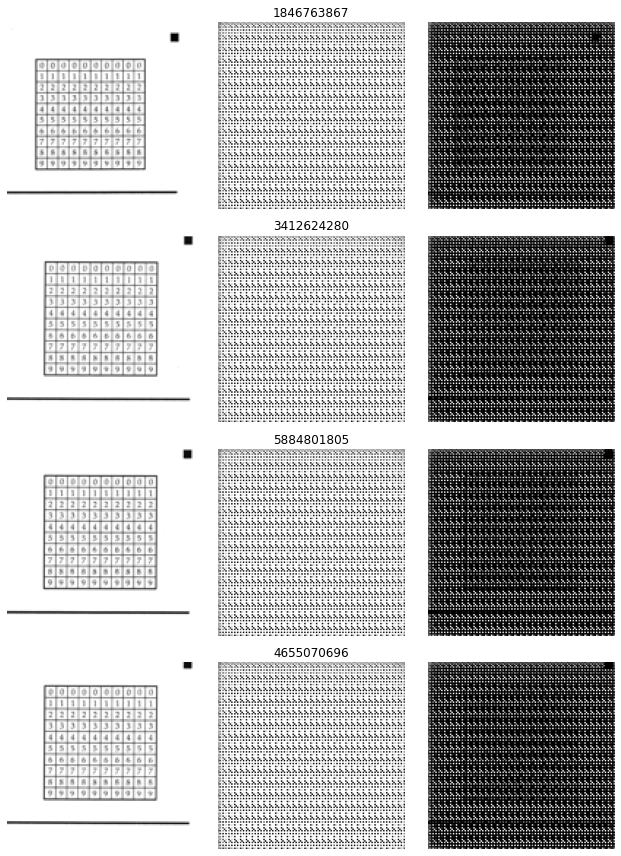

Epoch 2/10
 12/112 [==>...........................] - ETA: 1:31 - d_loss: -165963952128.0000 - g_wg_loss: -36280456704.0000 - g_id_loss: 0.0000e+00

KeyboardInterrupt: 

In [45]:
cond_gan.fit(dataset, epochs=10, callbacks=[showCallbacks])